In [1]:
# Step 1: Imports and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from IPython import display


In [2]:
from scipy.optimize import curve_fit
def gaussian(x, A, mean, sigma):
    return A * np.exp(-(x - mean)**2 / (2 * sigma**2))

def fit_energy_spectrum(energies, bins=200, expand_window=False):
    counts, edges = np.histogram(energies, bins=bins)
    centers = (edges[:-1] + edges[1:]) / 2

    rms = np.std(energies)
    peak = centers[np.argmax(counts)]
    window = 2 * rms if expand_window else 1 * rms
    mask = (centers > peak - window) & (centers < peak + window)
    x_fit = centers[mask]
    y_fit = counts[mask]
    
    try:
        A0 = max(y_fit)
        sigma0 = rms
        popt, _ = curve_fit(
            gaussian,
            x_fit,
            y_fit,
            p0=[A0, peak, sigma0],
            bounds=([0, 0, 0], [np.inf, np.inf, np.inf])  # force sigma > 0
        )
        A, mean, sigma = popt
        resolution = sigma / mean * 100
        return centers, counts, mean, sigma, resolution
    except Exception as e:
        print(f"Fit failed: {e}")
        return centers, counts, None, None, None

In [3]:
# Step 2: Load waveform data and MWD energies
# Assuming you have the waveform CSV and a matching CSV of MWD energies
waveform_df = pd.read_csv("../data/run0006/layer4_x2_y0.csv")
mwd_energy_df = pd.read_csv("../output/MWDenergies_layer4_x2_y0.csv")


In [4]:
# Extract waveforms and targets
X = waveform_df[[c for c in waveform_df.columns if c.startswith("t")]].values
y = mwd_energy_df["MWD_energy"].values

In [13]:
_, _, mean, sigma, resolution = fit_energy_spectrum(y)
print(f"MWD resolution: {resolution:.4f}%")

MWD resolution: 1.4951%


In [5]:
# Optional: Baseline subtract
X = X - np.mean(X[:, 20:80], axis=1, keepdims=True)

In [6]:
# Step 3: Train/test split and normalization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# Step 4: PyTorch dataset and loader
class WaveformDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = WaveformDataset(X_train, y_train)
test_ds = WaveformDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256)


In [8]:
# Step 5: Define simple MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=X.shape[1])
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

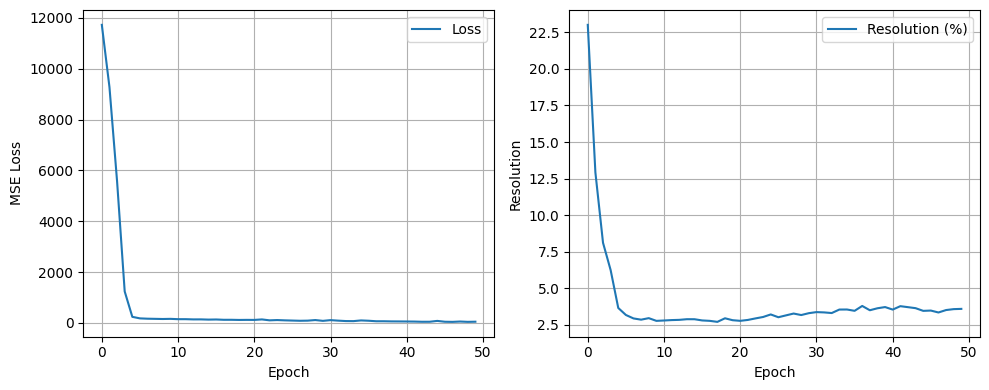

In [9]:
# Step 6: Training loop
n_epochs = 50
losses = []
resolutions = []

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(xb)
    losses.append(total_loss / len(train_ds))

    # Evaluate
    model.eval()
    y_pred = []
    with torch.no_grad():
        for xb, _ in test_loader:
            y_pred.extend(model(xb).squeeze().numpy())
    resolution = fit_energy_spectrum(np.array(y_pred))[-1]
    resolutions.append(resolution)

    # Live plot
    display.clear_output(wait=True)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(losses, label="Loss")
    plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
    plt.grid(True); plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(resolutions, label="Resolution (%)")
    plt.xlabel("Epoch"); plt.ylabel("Resolution")
    plt.grid(True); plt.legend()
    plt.tight_layout()
    plt.show()
   


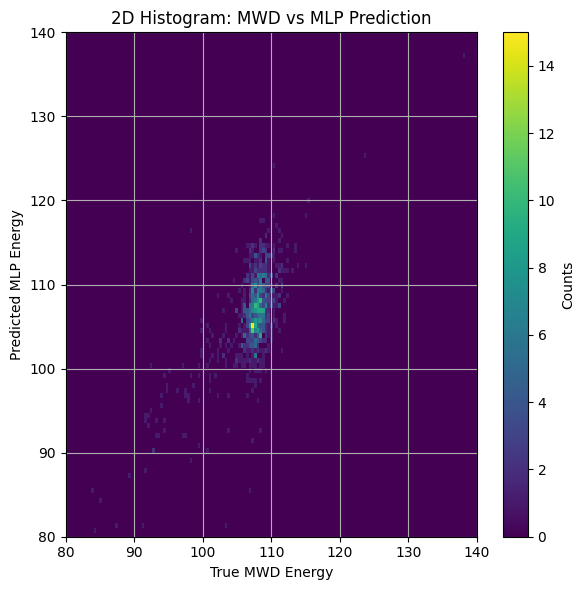

In [10]:
# Step 7: Evaluation and plotting
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for xb, yb in test_loader:
        pred = model(xb)
        y_pred.extend(pred.squeeze().numpy())
        y_true.extend(yb.squeeze().numpy())

plt.figure(figsize=(6, 6))
plt.hist2d(y_true, y_pred, bins=1000, cmap='viridis')
plt.xlabel("True MWD Energy")
plt.ylabel("Predicted MLP Energy")
plt.xlim(80,140)
plt.ylim(80,140)
plt.title("2D Histogram: MWD vs MLP Prediction")
plt.grid(True)
plt.colorbar(label="Counts")
plt.tight_layout()
plt.show()


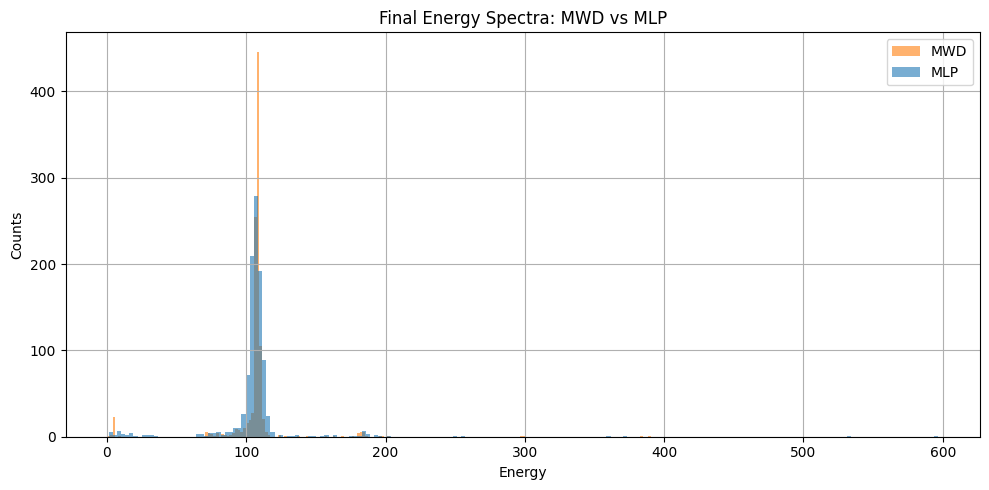

In [11]:
# Step 7: Final evaluation
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for xb, yb in test_loader:
        pred = model(xb)
        y_pred.extend(pred.squeeze().numpy())
        y_true.extend(yb.squeeze().numpy())

plt.figure(figsize=(10, 5))
plt.hist(y_true, bins=200, alpha=0.6, label="MWD", color="C1")
plt.hist(y_pred, bins=200, alpha=0.6, label="MLP", color="C0")
plt.xlabel("Energy")
plt.ylabel("Counts")
plt.legend()
plt.grid(True)
plt.title("Final Energy Spectra: MWD vs MLP")
plt.tight_layout()
plt.show()


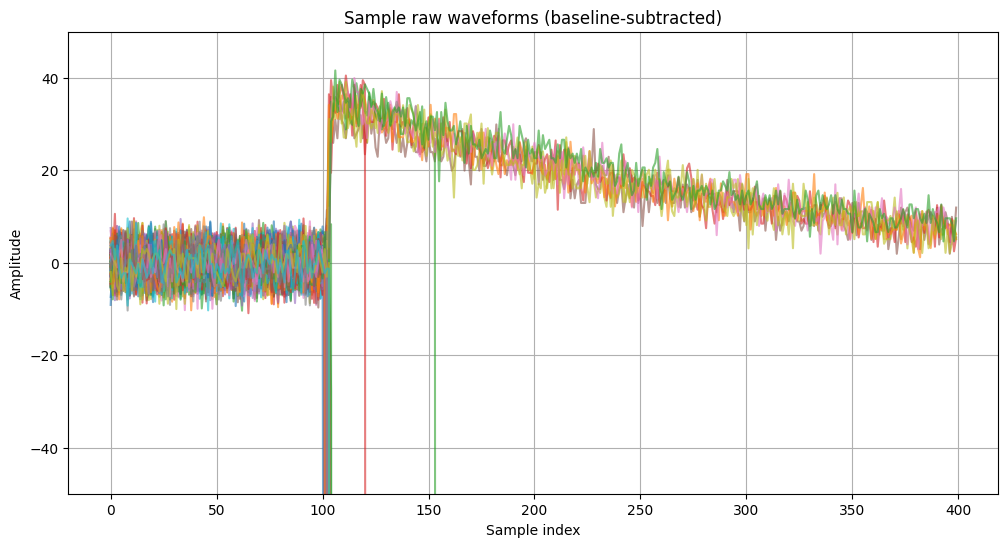

In [26]:
# Plot a few sample waveforms
plt.figure(figsize=(12, 6))
for i in range(200):
    plt.plot(X[i], alpha=0.6)
plt.title("Sample raw waveforms (baseline-subtracted)")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.ylim(-50,50)
plt.grid(True)
plt.show()

In [17]:
pulse_window = (100, 250)

In [30]:
def is_strange(wf, threshold=20.0):
    # Too flat?
    #print(np.std(wf))
    if np.std(wf) < threshold:
        return True
    # Positive pulse? (check min and max)
    if np.max(wf) > threshold:
        return True
    # Multiple peaks? (roughly: drop and re-rise)
    diff = np.diff(wf)
    if np.sum(diff[:50] < 0) > 30 and np.sum(diff[50:] > 0) > 30:
        return True
    return False


In [31]:
mask = np.array([not is_strange(wf) for wf in X])
X_clean = X[mask]
y_clean = y[mask]
print(f"Filtered {len(X) - len(X_clean)} strange pulses")

Filtered 98 strange pulses


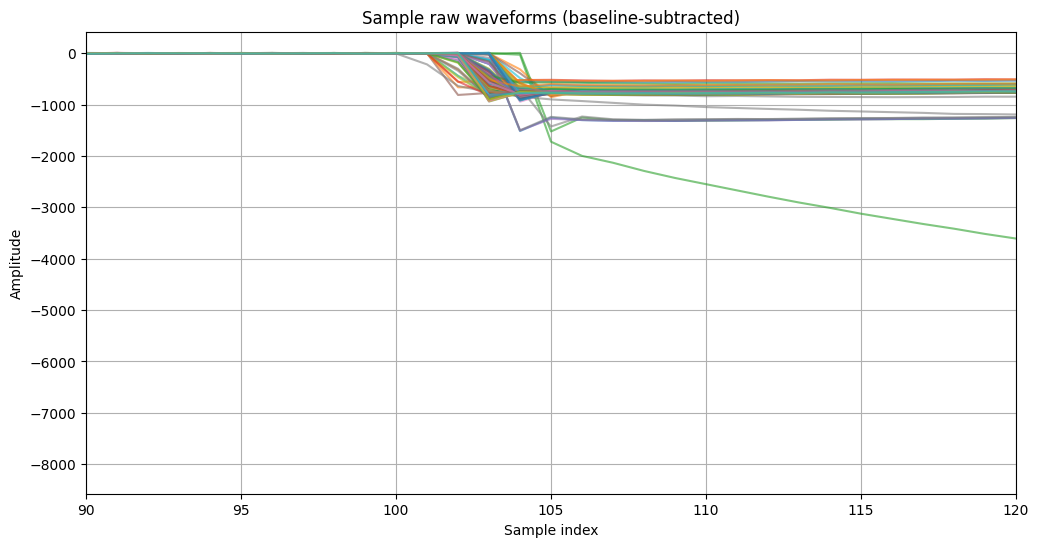

In [34]:
# Plot a few sample waveforms
plt.figure(figsize=(12, 6))
for i in range(200):
    plt.plot(X_clean[i], alpha=0.6)
plt.title("Sample raw waveforms (baseline-subtracted)")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.xlim(90,120)
plt.grid(True)
plt.show()

In [35]:
X_window = X_clean[:, pulse_window[0]:pulse_window[1]]

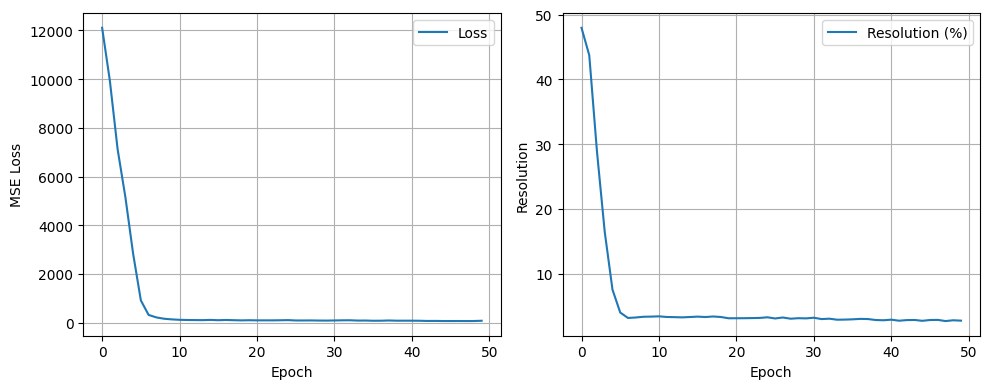

In [39]:
# Step 3: Train/test split and normalization
X_train, X_test, y_train, y_test = train_test_split(X_window, y_clean, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
train_ds = WaveformDataset(X_train, y_train)
test_ds = WaveformDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256)
n_epochs = 50
losses = []
resolutions = []
model = MLP(input_dim=X_window.shape[1])
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(xb)
    losses.append(total_loss / len(train_ds))

    # Evaluate
    model.eval()
    y_pred = []
    with torch.no_grad():
        for xb, _ in test_loader:
            y_pred.extend(model(xb).squeeze().numpy())
    resolution = fit_energy_spectrum(np.array(y_pred))[-1]
    resolutions.append(resolution)

    # Live plot
    display.clear_output(wait=True)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(losses, label="Loss")
    plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
    plt.grid(True); plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(resolutions, label="Resolution (%)")
    plt.xlabel("Epoch"); plt.ylabel("Resolution")
    plt.grid(True); plt.legend()
    plt.tight_layout()
    plt.show()

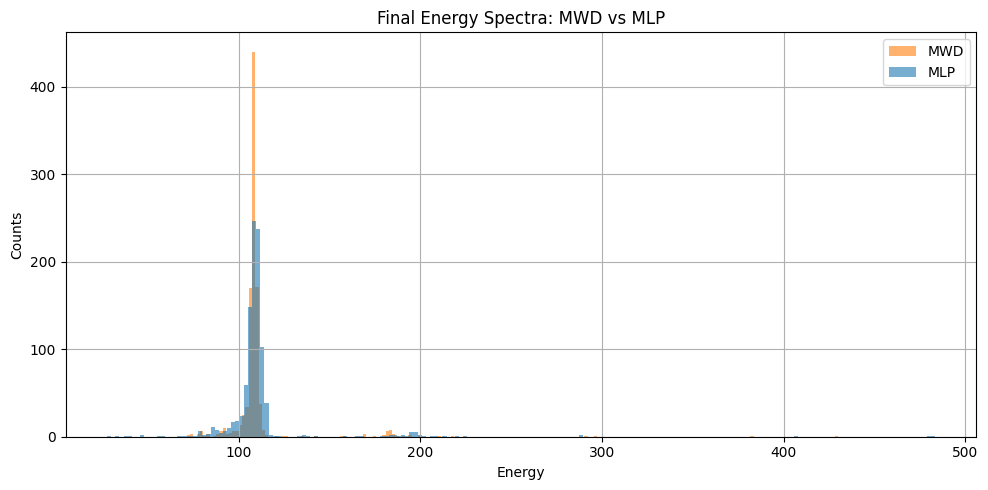

In [40]:
# Step 9: Final evaluation
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for xb, yb in test_loader:
        pred = model(xb)
        y_pred.extend(pred.squeeze().numpy())
        y_true.extend(yb.squeeze().numpy())

plt.figure(figsize=(10, 5))
plt.hist(y_true, bins=200, alpha=0.6, label="MWD", color="C1")
plt.hist(y_pred, bins=200, alpha=0.6, label="MLP", color="C0")
plt.xlabel("Energy")
plt.ylabel("Counts")
plt.legend()
plt.grid(True)
plt.title("Final Energy Spectra: MWD vs MLP")
plt.tight_layout()
plt.show()
